In [2]:
import random, os
from pathlib import Path
import numpy  as np

# do this before importing tensorflow to get rid of annoying warning messages
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
import matplotlib.pyplot as plt

In [3]:
# specify image size
target_shape = (200,200)   #(245, 200)

#### Data Preparation

In [5]:
"""
    load image jpeg image from file and resize into the target shape
"""
def preprocess_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, target_shape)
    return img

""" 
    preprocess a triplet of images given their filenames
"""
def preprocess_triplets(anchor, positive, negative):
    return (preprocess_image(anchor), preprocess_image(positive), preprocess_image(negative))



In [6]:
anchor_images_path = "./dataset/left/"
positive_images_path = "./dataset/right/"
batch_size = 32

In [10]:
# load anchor and positive images (make sure they're in the right order) 
anchor_images = sorted([str(anchor_images_path + f) for f in os.listdir(anchor_images_path)])
positive_images = sorted([str(positive_images_path + f) for f in os.listdir(positive_images_path)])
image_count = len(anchor_images)

# create tensorflow datasets
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

# create a negative dataset from the combines shuffled images
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

# create a triplet dataset
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)

# convert filenames to preprocessed images
dataset = dataset.map(preprocess_triplets) 

# 80-20 training and validation splits
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(batch_size, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

2023-10-12 19:09:43.372314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-12 19:09:43.460828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-12 19:09:43.461327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-12 19:09:43.465848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-12 19:09:43.466229: I tensorflow/compile

#### Visualising the dataset

2023-10-12 19:17:28.113878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6016]
	 [[{{node Placeholder/_0}}]]
2023-10-12 19:17:28.114154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [12032]
	 [[{{node Placeholder/_4}}]]


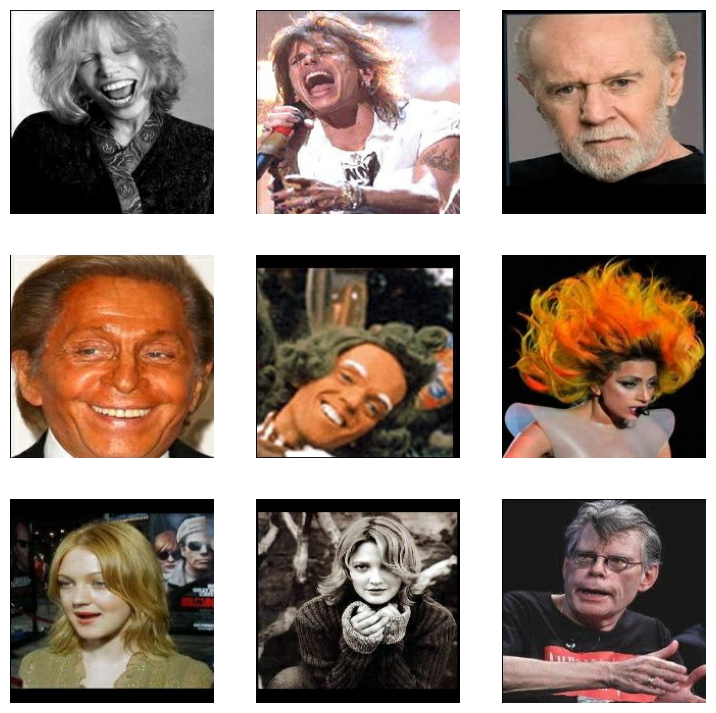

In [17]:
def visualize(anchor, positive, negative):
    
    def show(ax, image):
        ax.imshow(image)
        ax.axis('off')
        

    fig = plt.figure(figsize=(9, 9))
    axs = fig.subplots(3, 3)
        
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])


#### Feature extractor network 

We will use ResNet50, pretrained on ImageNet, to extract features from the images. All layers preceding `conv5_block1_out` will be frozen, the weights in the remaining layers above will be fine-tuned

In [19]:
feature_dims = 256

base_cnn = resnet.ResNet50(weights="imagenet", input_shape=target_shape + (3,), include_top=False) # we do not include the ResNet50 output layer

# additional layers on top of resnet 
flatten = layers.Flatten() (base_cnn.output)
output = layers.Dense(512, activation='relu')(flatten)
output = layers.BatchNormalization()(output)
output = layers.Dense(256, activation='relu')(flatten)
output = layers.BatchNormalization()(output)
output = layers.Dense(feature_dims, activation='relu')(flatten)

# combine into a new model
feature_extractor = Model(base_cnn.input, output, name="feature_extractor")

# freeze the weights up to layer conv5_block1_out
trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

feature_extractor.summary()

Model: "feature_extractor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                  

#### Siamese network with custom training loop 

The siamese network takes each of the triplet images, extracts features and outputs the L2-distance between the achor image and positive and negative images. The triplet loss function is used to compute the loss, defined as follows:

$L(A,P,N) = Max(Dist(A,P) - Dist(A,N) + margin, 0.0)$

In [35]:
"""
    A custom layer for computing the distance between extracted features of anchor image and positive/negative images
"""
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        # compute l2-distance between anchor and positive image
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        # compute l2-distance between anchor and negative image
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

anchor_input = layers.Input(shape=target_shape + (3,), name="anchor")    
positive_input = layers.Input(shape=target_shape + (3,), name="positive")    
negative_input = layers.Input(shape=target_shape + (3,), name="negative")    

distances = DistanceLayer()(feature_extractor(anchor_input), feature_extractor(positive_input), feature_extractor(negative_input))

# define the siamese network model
siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs = distances)

In [30]:
# define custom training loop
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")
  

    def call(self, inputs):    
        return self.siamese_network(inputs)
    

    # custom training step    
    def train_step(self, data):
        # forward propagation on gradient tape
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # compute the loss gradients 
        grads = tape.gradient(loss, self.siamese_network.trainable_weights)

        # backproagation
        self.optimizer.apply_gradients(zip(grads,self.siamese_network.trainable_weights))

        # update the loss metric
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
     

    # custom testing step
    def test_step(self, data):
        loss = self._compute_loss(data)
        # update the loss metric.
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}


    # define the triplet loss function
    def _compute_loss(self, data):
        # compute distance of anchor from positive and negative images
        ap_distance, an_distance = self.siamese_network(data)
        # compute the triplet loss (we want to minimize ap_distance and maximise an_distance,
        # which is why there's a minus sign infront of an_distance, we also allow for a small margin) 
        loss = ap_distance - an_distance + self.margin   
        # make sure the loss value is non-negative
        loss = tf.maximum(loss, 0.0)
        
        return loss


    @property
    def metrics(self):
        return [self.loss_tracker]

#### Now, let's train this model

In [31]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))

In [32]:
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


2023-10-12 20:01:15.122254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-12 20:01:20.529670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-12 20:01:22.365204: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x35b00c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-12 20:01:22.365245: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-10-12 20:01:22.388589: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-12 20:01:22.595466: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime o

151/151 [==============================] - ETA: 0s - loss: 0.5103

2023-10-12 20:01:53.773915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6016]
	 [[{{node Placeholder/_0}}]]
2023-10-12 20:01:53.774169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [6016]
	 [[{{node Placeholder/_2}}]]


151/151 [==============================] - 54s 256ms/step - loss: 0.5103 - val_loss: 0.3839
Epoch 2/10
151/151 [==============================] - 34s 224ms/step - loss: 0.3925 - val_loss: 0.3716
Epoch 3/10
151/151 [==============================] - 34s 223ms/step - loss: 0.3793 - val_loss: 0.3859
Epoch 4/10
151/151 [==============================] - 34s 224ms/step - loss: 0.3558 - val_loss: 0.3784
Epoch 5/10
151/151 [==============================] - 34s 224ms/step - loss: 0.3411 - val_loss: 0.3484
Epoch 6/10
151/151 [==============================] - 34s 225ms/step - loss: 0.3285 - val_loss: 0.3086
Epoch 7/10
151/151 [==============================] - 34s 225ms/step - loss: 0.3170 - val_loss: 0.3079
Epoch 8/10
151/151 [==============================] - 34s 226ms/step - loss: 0.3068 - val_loss: 0.3308
Epoch 9/10
151/151 [==============================] - 35s 230ms/step - loss: 0.3016 - val_loss: 0.3272
Epoch 10/10
151/151 [==============================] - 34s 227ms/step - loss: 0.2979

#### Evaluating the trained siamese network on the validation dataset

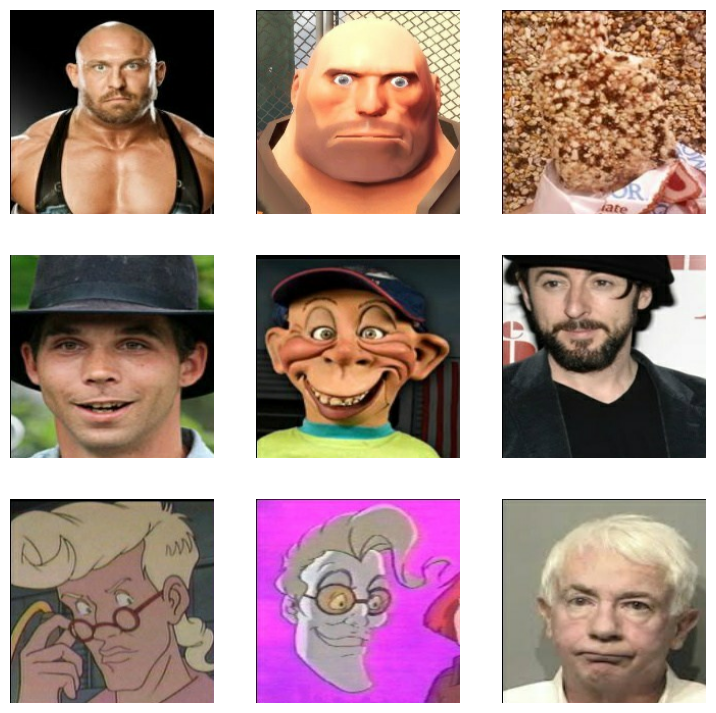

In [49]:
# pick a sample triplet
sample = next(iter(val_dataset))
visualize(*sample)

In [50]:
print(sample)

(<tf.Tensor: shape=(32, 200, 200, 3), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 3.92156886e-03, 0.00000000e+00],
         [0.00000000e+00, 3.92156886e-03, 0.00000000e+00],
         [0.00000000e+00, 7.84313772e-03, 3.92156886e-03]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 3.92156886e-03, 0.00000000e+00],
         [0.00000000e+00, 3.92156886e-03, 0.00000000e+00],
         [0.00000000e+00, 7.84313772e-03, 3.92156886e-03]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         

#### Compute the l2 distance between the anchor and positive/negative images

In [48]:
anchor, positive, negative = sample

anchor_features, positive_features, negative_features = (feature_extractor(resnet.preprocess_input(anchor)), feature_extractor(resnet.preprocess_input(positive)), feature_extractor(resnet.preprocess_input(negative)))

In [40]:
mse = metrics.MeanSquaredError()

positive_distance = mse(anchor_features, positive_features)
negative_distance = mse(anchor_features, negative_features)

print(f"Dist(A,P) = {positive_distance.numpy()}, Dist(A,N) = {negative_distance.numpy()}")

Dist(A,P) = 0.0009992362465709448, Dist(A,N) = 0.0011706722434610128


The positive image has smaller l2 distance than the negative image!

In [55]:
size_of_dataset = tf.data.experimental.cardinality(val_dataset).numpy()
print(size_of_dataset)

151


In [60]:
num_correct = 0
i = 0
for (anchor_batch, positive_batch, negative_batch) in val_dataset:
    #print(anchor_batch.numpy().shape)
    #print(positive_batch.numpy().shape)
    #print(negative_batch.numpy().shape)
    for (anchor, positive, negative) in zip(anchor_batch, positive_batch, negative_batch):
        anchor = tf.expand_dims(anchor, axis=0)
        positive = tf.expand_dims(positive, axis=0)
        negative = tf.expand_dims(negative, axis=0)
        anchor_features, positive_features, negative_features = (feature_extractor(resnet.preprocess_input(anchor)), feature_extractor(resnet.preprocess_input(positive)), feature_extractor(resnet.preprocess_input(negative)))
        
        positive_distance = mse(anchor_features, positive_features)
        negative_distance = mse(anchor_features, negative_features)
        correct = positive_distance.numpy() < negative_distance.numpy()
        if correct:
            num_correct += 1

        print(f"Sample#{i} --> Dist(A,P) = {positive_distance.numpy()}, Dist(A,N) = {negative_distance.numpy()} Correct: {correct}")
        i += 1

print(f"Accuracy = {num_correct/(i+1)}")

Sample#0 --> Dist(A,P) = 0.001416406943462789, Dist(A,N) = 0.0014164946042001247 Correct: True
Sample#1 --> Dist(A,P) = 0.0014164169551804662, Dist(A,N) = 0.0014163630548864603 Correct: False
Sample#2 --> Dist(A,P) = 0.0014162786537781358, Dist(A,N) = 0.0014161921571940184 Correct: False
Sample#3 --> Dist(A,P) = 0.0014168638736009598, Dist(A,N) = 0.0014168655034154654 Correct: True
Sample#4 --> Dist(A,P) = 0.001416851649992168, Dist(A,N) = 0.0014169234782457352 Correct: True
Sample#5 --> Dist(A,P) = 0.0014173111412674189, Dist(A,N) = 0.0014175367541611195 Correct: True
Sample#6 --> Dist(A,P) = 0.0014176255790516734, Dist(A,N) = 0.0014176939148455858 Correct: True
Sample#7 --> Dist(A,P) = 0.0014176109107211232, Dist(A,N) = 0.0014175978722050786 Correct: False
Sample#8 --> Dist(A,P) = 0.0014175859978422523, Dist(A,N) = 0.0014175536343827844 Correct: False
Sample#9 --> Dist(A,P) = 0.0014175284886732697, Dist(A,N) = 0.0014175067190080881 Correct: False
Sample#10 --> Dist(A,P) = 0.001417699